In [ ]:
!pip install gdeltdoc pandas tqdm pyarrow statsmodels tigramite tqdm matplotlib seaborn plotly wordcloud japanize-matplotlib nbformat
!pip install "dask[complete]" 

## 目的
世界中のニュースメディアを監視する大規模データベース**GDELT**のデータを活用し、どのようなデータを含んでいてるか可視化をしながら確認する。

## GDELTプロジェクトとは
GDELT（Global Database of Events, Language, and Tone）は、世界中のニュース記事をリアルタイムで収集・分析し、「誰が、誰に、何をしたか」というイベント情報を構造化データとして提供している。

### EventRootCode
これはイベントを大まかに分類する2桁の数字で全部で20のカテゴリがある。 \
大まかに協力的なイベントと対立的なイベントに分ける。 \
3桁以上の数字でより細かい値を出すことができる。 \
https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt \

協力的なイベントの例: \
01: MAKE PUBLIC STATEMENT (公式声明を発表) \
02: APPEAL (要請・アピール) \
03: EXPRESS INTENT TO COOPERATE (協力の意図を表明) \
04: CONSULT (協議する) \
05: ENGAGE IN DIPLOMATIC COOPERATION (外交協力を行う) \
対立的なイベントの例: \
10: DEMAND (要求する) \
11: DISAPPROVE (非難する) \
12: REJECT (拒否する) \
13: THREATEN (脅迫する) \
14: PROTEST (抗議する) \
19: USE CONVENTIONAL MILITARY FORCE (通常戦力を行使する) \

### Goldsteinスケール
各イベントコードに割り当てられた、-10（極めて対立的）から+10（極めて協力的）までのスコア。国家間の関係性の安定度を測る指標。

### Average Tone
ニュース記事全体の感情的なトーンを示す指標。-100（極端にネガティブ）から+100（極端にポジティブ）までの値を取り、メディアの論調を測る指標。




In [2]:
import os
import zipfile
import requests
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from datetime import datetime, timedelta
from tqdm import tqdm
import logging
import gc 


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

BASE = "http://data.gdeltproject.org/events"
OUT  = Path("data") 
OUT.mkdir(exist_ok=True)


start_date = datetime(2022, 4, 1)
end_date   = datetime(2025, 6, 9) 

current_date = start_date
downloaded_files = []

logging.info(f"Starting download process for dates: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

while current_date <= end_date:
    fname = f"{current_date:%Y%m%d}.export.CSV.zip"
    url   = f"{BASE}/{fname}"
    local_zip_path = OUT / fname

    if not local_zip_path.exists():
        logging.info(f"Downloading {fname} from {url}...")
        try:
            r = requests.get(url, stream=True, timeout=60) 
            r.raise_for_status()
            
            content_type = r.headers.get('content-type', '').lower()
            is_zip_content = 'application/zip' in content_type or \
                             'application/octet-stream' in content_type or \
                             'application/x-zip-compressed' in content_type
            

            content_length = int(r.headers.get('content-length', 0)) 
            
            if not is_zip_content and content_length < 10000 and 'text/html' in content_type:
                logging.warning(f"Skipping {fname}: Unexpected content-type '{content_type}' and small size ({content_length} bytes). Might be an error page.")
                current_date += timedelta(days=1)
                continue
            if is_zip_content and content_length > 0 and content_length < 1024: 
                 logging.warning(f"Skipping {fname}: ZIP file size ({content_length} bytes) is suspiciously small. May be empty or corrupted.")
                 current_date += timedelta(days=1)
                 continue


            with open(local_zip_path, "wb") as f:
                for chunk in r.iter_content(1024*1024):
                    f.write(chunk)
            
            try:
                with zipfile.ZipFile(local_zip_path, 'r') as test_zf:
                    if not test_zf.namelist():
                        logging.warning(f"Downloaded file {fname} is an empty ZIP. Deleting and skipping.")
                        local_zip_path.unlink() 
                        current_date += timedelta(days=1)
                        continue
                logging.info(f"Successfully downloaded and verified {fname}")
                downloaded_files.append(local_zip_path)
            except zipfile.BadZipFile:
                logging.error(f"Downloaded file {fname} is not a valid ZIP. Deleting and skipping.")
                if local_zip_path.exists(): local_zip_path.unlink()
                current_date += timedelta(days=1)
                continue
                
        except requests.exceptions.HTTPError as e:
            logging.error(f"HTTP error downloading {fname}: {e}. Server might not have this file yet or other issue.")
        except requests.exceptions.RequestException as e:
            logging.error(f"Error downloading {fname}: {e}")
            if local_zip_path.exists():
                try:
                    local_zip_path.unlink(missing_ok=True)
                except OSError: pass 
        except Exception as e:
            logging.error(f"An unexpected error occurred during download of {fname}: {e}")
    else:
        logging.info(f"{fname} already exists. Assuming valid and adding to process list.")
        downloaded_files.append(local_zip_path)
    
    current_date += timedelta(days=1)

logging.info(f"Download process finished. {len(downloaded_files)} files to process.")
if not downloaded_files:
    logging.warning("No files were downloaded or found. Exiting processing.")
    exit()
    
logging.info("Starting Parquet conversion and writing process...")

usecols_super_enhanced = [
    0, 1, 6, 7, 12, 16, 17, 22, 25, 26, 29, 30, 31, 34, 52, 53, 54, 55, 56, 57
]
colnames_super_enhanced = [
    "GLOBALEVENTID", "SQLDATE",
    "Actor1Name", "Actor1CountryCode", "Actor1Type1Code",
    "Actor2Name", "Actor2CountryCode", "Actor2Type1Code",
    "EventCodeFull", "EventRootCode", "QuadClass", "GoldsteinScale",
    "NumMentions", "AvgTone",
    "ActionGeo_Fullname", "ActionGeo_CountryCode", "ActionGeo_ADM1Code", 
    "ActionGeo_Lat", "ActionGeo_Long",
    "SOURCEURL"
]


parquet_schema = pa.schema([
    pa.field("GLOBALEVENTID", pa.string()),
    pa.field("SQLDATE", pa.timestamp('ms')), 
    pa.field("Actor1Name", pa.string()),
    pa.field("Actor1CountryCode", pa.string()), 
    pa.field("Actor1Type1Code", pa.string()),
    pa.field("Actor2Name", pa.string()),
    pa.field("Actor2CountryCode", pa.string()),
    pa.field("Actor2Type1Code", pa.string()),
    pa.field("EventCodeFull", pa.string()),
    pa.field("EventRootCode", pa.string()),
    pa.field("QuadClass", pa.int8()),
    pa.field("GoldsteinScale", pa.float32()),
    pa.field("NumMentions", pa.int32()),
    pa.field("AvgTone", pa.float32()),
    pa.field("ActionGeo_Fullname", pa.string()),
    pa.field("ActionGeo_CountryCode", pa.string()),
    pa.field("ActionGeo_ADM1Code", pa.string()),
    pa.field("ActionGeo_Lat", pa.float32()),
    pa.field("ActionGeo_Long", pa.float32()),
    pa.field("SOURCEURL", pa.string())
])

csv_dtypes = {
    1: str,
    30: str,
    31: str,
    34: str,
    29: str,
    55: str,
    56: str,
}

output_filename = f"gdelt_events_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.parquet"
output_parquet_path = OUT / output_filename 
parquet_writer = None
total_rows_written = 0

try:
    for zpath in tqdm(downloaded_files, desc="Processing ZIP files to Parquet"):
        if not zpath.exists():
            logging.warning(f"File {zpath} was in list but not found on disk. Skipping.")
            continue
        
        df = None
        table = None 

        try:
            with zipfile.ZipFile(zpath, 'r') as zf:
                if not zf.namelist():
                    logging.warning(f"ZIP file {zpath.name} is empty. Skipping.")
                    continue
                
                csv_filename_in_zip = zf.namelist()[0]
                with zf.open(csv_filename_in_zip) as f:
                    df = pd.read_csv(
                        f,
                        sep="\t",
                        header=None,
                        names=None, 
                        usecols=usecols_super_enhanced,
                        dtype=str,
                        engine="c", 
                        low_memory=False,
                        on_bad_lines="skip"
                    )
            
            if df.empty:
                logging.warning(f"DataFrame from {zpath.name} is empty after read_csv. Skipping.")
                continue

            if df.shape[1] == len(colnames_super_enhanced):
                df.columns = colnames_super_enhanced

                try:
                    df["SQLDATE"] = pd.to_datetime(df["SQLDATE"], format='%Y%m%d', errors='coerce')
                    df.dropna(subset=["SQLDATE"], inplace=True) 
                    if df.empty:
                        logging.warning(f"No valid SQLDATE entries in {zpath.name} after coercion. Skipping.")
                        continue

                    df["NumMentions"] = pd.to_numeric(df["NumMentions"], errors='coerce').astype('Int32')
                    df["AvgTone"] = pd.to_numeric(df["AvgTone"], errors='coerce').astype('float32')
                    df["GoldsteinScale"] = pd.to_numeric(df["GoldsteinScale"], errors='coerce').astype('float32')
                    df["QuadClass"] = pd.to_numeric(df["QuadClass"], errors='coerce').astype('Int8') # pandas nullable Int8
                    df["ActionGeo_Lat"] = pd.to_numeric(df["ActionGeo_Lat"], errors='coerce').astype('float32')
                    df["ActionGeo_Long"] = pd.to_numeric(df["ActionGeo_Long"], errors='coerce').astype('float32')
                    

                    for col_name in colnames_super_enhanced:
                        if df[col_name].dtype == 'object':
                            df[col_name] = df[col_name].fillna('')

                except Exception as e_convert_daily:
                    logging.error(f"Error during type conversion for {zpath.name}: {e_convert_daily}. Skipping this file.")
                    continue
                
                if df.empty:
                    logging.warning(f"DataFrame from {zpath.name} became empty after type conversion. Skipping.")
                    continue
                
                try:
                    table = pa.Table.from_pandas(df, schema=parquet_schema, preserve_index=False)
                except Exception as e_to_arrow:
                    logging.error(f"Error converting DataFrame from {zpath.name} to Arrow Table: {e_to_arrow}. Skipping this file.")
                    logging.error(f"DataFrame dtypes at point of failure for {zpath.name}:\n{df.dtypes.to_string()}")
                    continue

                if parquet_writer is None:
                    parquet_writer = pq.ParquetWriter(output_parquet_path, parquet_schema, compression='snappy')
                
                parquet_writer.write_table(table)
                total_rows_written += len(df)

            else:
                logging.warning(f"Skipping data from {zpath.name}: Expected {len(colnames_super_enhanced)} columns but got {df.shape[1]}. `on_bad_lines='skip'` might have affected row structure.")

        except zipfile.BadZipFile:
            logging.error(f"File {zpath.name} is not a valid ZIP file or is corrupted. Skipping.")
        except pd.errors.EmptyDataError:
            logging.warning(f"No data or columns to parse in {zpath.name} (or its CSV). Skipping.")
        except pd.errors.ParserError as e:
            logging.error(f"Error parsing CSV from {zpath.name}: {e}. Skipping.")
        except IndexError: 
            logging.error(f"Could not access file list in zip {zpath.name}, it might be empty or malformed. Skipping.")
        except Exception as e:
            logging.error(f"An unexpected error occurred while processing {zpath.name}: {e}. Skipping.")
        finally:
            del df
            del table
            gc.collect()

finally:
    if parquet_writer:
        parquet_writer.close()
        logging.info(f"Parquet writer closed. Total rows written to {output_parquet_path}: {total_rows_written}")
    elif total_rows_written == 0 and downloaded_files:
         logging.warning("No data was written to Parquet file, though files were processed.")


if total_rows_written > 0:
    logging.info(f"Successfully saved data to {output_parquet_path}. Total rows: {total_rows_written}")
else:
    logging.warning("No dataframes were processed successfully or no rows were written. Parquet file might be empty or not created if no valid data was found.")

logging.info("Script finished.")


2025-06-09 23:07:36,234 - INFO - Starting download process for dates: 2022-04-01 to 2025-06-09
2025-06-09 23:07:36,236 - INFO - 20220401.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,237 - INFO - 20220402.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,240 - INFO - 20220403.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,241 - INFO - 20220404.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,242 - INFO - 20220405.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,243 - INFO - 20220406.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,244 - INFO - 20220407.export.CSV.zip already exists. Assuming valid and adding to process list.
2025-06-09 23:07:36,246 - INFO - 20220408.export.CSV.zip already exists. Assuming valid and a

[########################################] | 100% Completed | 24.30 s
[######################################  ] | 97% Completed | 344.42 s

IOStream.flush timed out


[########################################] | 100% Completed | 347.49 s
[########################################] | 100% Completed | 17.51 s


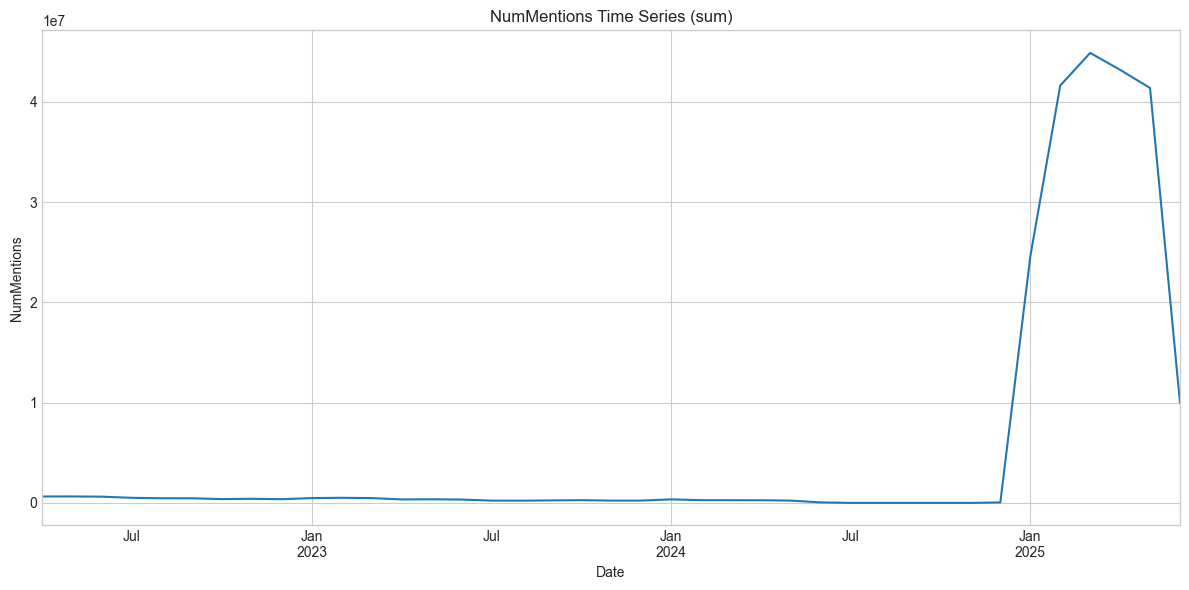

[########################################] | 100% Completed | 17.91 s


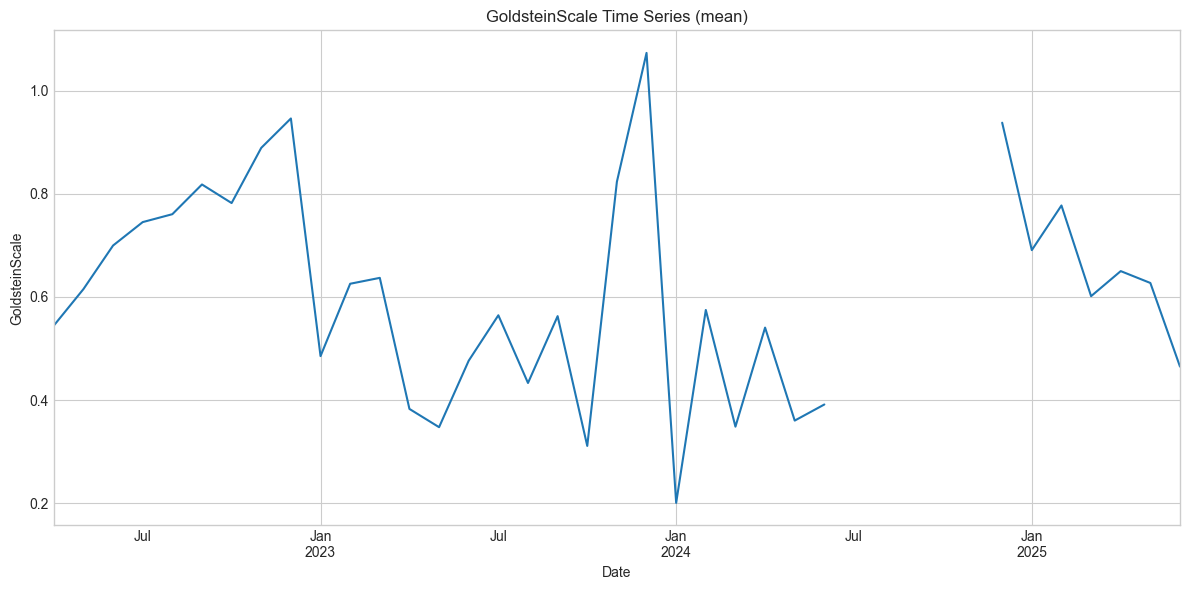

[######                                  ] | 15% Completed | 62.83 ss

IOStream.flush timed out
IOStream.flush timed out


[########################################] | 100% Completed | 238.92 s


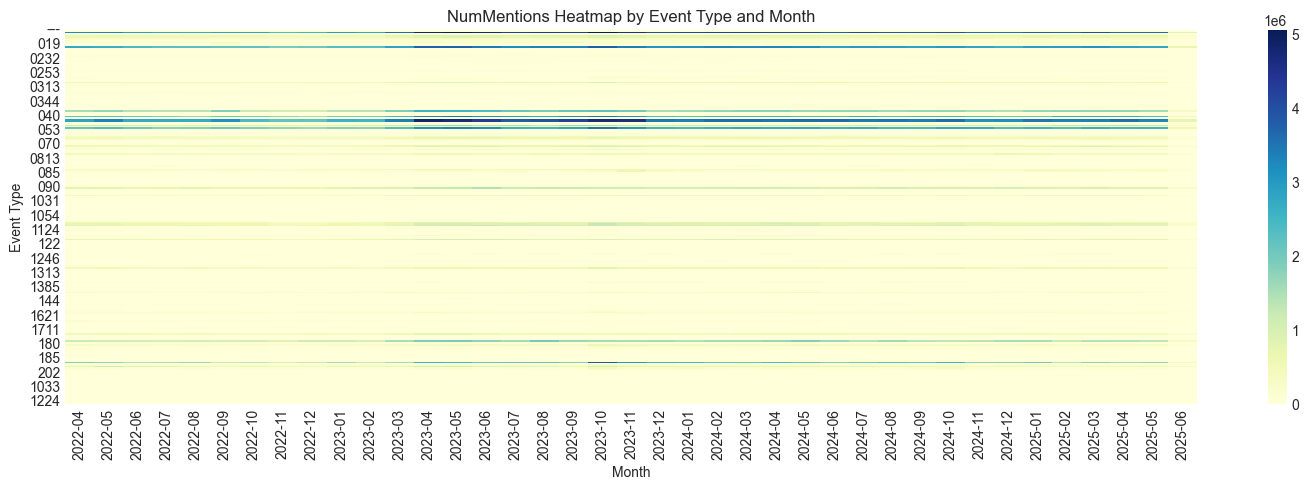

[########################################] | 100% Completed | 499.02 s
[############                            ] | 30% Completed | 49.70 ss

IOStream.flush timed out


[###############                         ] | 39% Completed | 86.83 s

IOStream.flush timed out


[########################################] | 100% Completed | 196.83 s


[###                                     ] | 7% Completed | 61.93 sms

IOStream.flush timed out
IOStream.flush timed out


[########################################] | 100% Completed | 443.29 s
[####################                    ] | 51% Completed | 106.21 s

IOStream.flush timed out


[########################################] | 100% Completed | 159.02 s


Visualization processes completed.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from wordcloud import WordCloud
import re
from collections import Counter
from pathlib import Path
from datetime import datetime

try:
    import japanize_matplotlib
except ImportError:
    pass

plt.rcParams['axes.unicode_minus'] = False

wordcloud_font_path = None
try:
    font_name_for_wc = 'IPAexGothic'
    font_prop_wc = fm.FontProperties(family=font_name_for_wc)
    found_path = fm.findfont(font_prop_wc, fallback_to_default=False)
    if found_path and Path(found_path).exists():
        wordcloud_font_path = found_path
except Exception:
    pass


def load_gdelt_data_dask(gdelt_path_str, target_start_date=None, target_end_date=None, columns_to_load=None):
    ddf_gdelt = None
    gdelt_path = Path(gdelt_path_str)

    if not (gdelt_path.is_dir() or (gdelt_path.is_file() and gdelt_path.suffix.lower() == '.parquet')):
        return None

    try:
        filters = []
        if target_start_date:
            filters.append(('SQLDATE', '>=', pd.Timestamp(target_start_date)))
        if target_end_date:
            filters.append(('SQLDATE', '<=', pd.Timestamp(target_end_date)))
        
        ddf_gdelt = dd.read_parquet(
            gdelt_path, 
            columns=columns_to_load,
            filters=filters if filters else None,
            engine='pyarrow' 
        )

        with ProgressBar():
            is_empty = ddf_gdelt.map_partitions(len).compute().sum() == 0
        
        if is_empty:
            return None

        if 'SQLDATE' in ddf_gdelt.columns:
            if not pd.api.types.is_datetime64_any_dtype(ddf_gdelt['SQLDATE'].dtype):
                ddf_gdelt['SQLDATE'] = dd.to_datetime(ddf_gdelt['SQLDATE'], errors='coerce')

        numeric_cols_meta = {
            'NumMentions': 'Int32', 'AvgTone': 'float32', 'GoldsteinScale': 'float32',
            'ActionGeo_Lat': 'float32', 'ActionGeo_Long': 'float32', 'QuadClass': 'Int8'
        }
        for col, dtype in numeric_cols_meta.items():
            if col in ddf_gdelt.columns:
                if ddf_gdelt[col].dtype == 'object': 
                    ddf_gdelt[col] = dd.to_numeric(ddf_gdelt[col], errors='coerce')
                
                if dtype in ['Int32', 'Int8'] and col == 'NumMentions': 
                     ddf_gdelt[col] = ddf_gdelt[col].fillna(0) 
                
                if ddf_gdelt[col].dtype.name.lower() != dtype.lower():
                    try:
                        ddf_gdelt[col] = ddf_gdelt[col].astype(dtype)
                    except Exception: 
                        pass
        
        categorical_cols = [
            'Actor1CountryCode', 'Actor2CountryCode', 'EventRootCode', 'EventCodeFull', 
            'Actor1Type1Code', 'Actor2Type1Code', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code',
            'Actor1Name', 'Actor2Name', 'ActionGeo_Fullname', 'SOURCEURL', 'GLOBALEVENTID'
        ]
        for col in categorical_cols:
            if col in ddf_gdelt.columns:
                ddf_gdelt[col] = ddf_gdelt[col].astype(str).fillna('')

    except Exception:
        return None
    return ddf_gdelt


def plot_gdelt_choropleth_plotly_dask(ddf_gdelt, column='NumMentions', agg_func='sum', actor_country_col='Actor1CountryCode'):
    if ddf_gdelt is None or ddf_gdelt.npartitions == 0 or actor_country_col not in ddf_gdelt.columns or column not in ddf_gdelt.columns:
        return
    ddf_gdelt_filtered = ddf_gdelt[ddf_gdelt[actor_country_col].astype(str).str.len() == 3].copy() 
    with ProgressBar(): 
        num_filtered_rows = ddf_gdelt_filtered.map_partitions(len).compute().sum()
    
    if num_filtered_rows == 0: return

    if agg_func == 'sum':
        country_data_dask = ddf_gdelt_filtered.groupby(actor_country_col)[column].sum()
    elif agg_func == 'mean':
        country_data_dask = ddf_gdelt_filtered.groupby(actor_country_col)[column].mean()
    elif agg_func == 'max':
        country_data_dask = ddf_gdelt_filtered.groupby(actor_country_col)[column].max()
    else: 
        return

    with ProgressBar(): 
        country_data_pd = country_data_dask.compute().reset_index()

    if country_data_pd.empty: return
    fig = px.choropleth(country_data_pd, locations=actor_country_col, color=column, hover_name=actor_country_col,
                        color_continuous_scale=px.colors.sequential.Plasma, title=f'{actor_country_col} - {column} ({agg_func})')
    fig.show()


def plot_gdelt_timeseries_matplotlib_dask(ddf_gdelt, date_col='SQLDATE', value_col='NumMentions', agg_func='sum'):
    if ddf_gdelt is None or ddf_gdelt.npartitions == 0 or date_col not in ddf_gdelt.columns or value_col not in ddf_gdelt.columns:
        return
    ddf_temp = ddf_gdelt[[date_col, value_col]].copy()
    ddf_temp = ddf_temp.dropna(subset=[date_col]) 

    if not pd.api.types.is_datetime64_any_dtype(ddf_temp[date_col].dtype):
        ddf_temp[date_col] = dd.to_datetime(ddf_temp[date_col], errors='coerce')
        ddf_temp = ddf_temp.dropna(subset=[date_col])

    ddf_indexed = ddf_temp.set_index(date_col, sorted=True)
    try:
        if agg_func == 'sum': 
            time_data_dask = ddf_indexed[value_col].resample('M').sum()
        elif agg_func == 'mean': 
            time_data_dask = ddf_indexed[value_col].resample('M').mean()
        elif agg_func == 'count': 
            time_data_dask = ddf_indexed[value_col].resample('M').count()
        else: return
        with ProgressBar(): 
            time_data_pd = time_data_dask.compute()
    except Exception: 
        return

    if time_data_pd.empty: return
    plt.figure(figsize=(12, 6))
    time_data_pd.plot(kind='line')
    plt.title(f'{value_col} Time Series ({agg_func})')
    plt.xlabel('Date')
    plt.ylabel(value_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_gdelt_type_heatmap_seaborn_dask(ddf_gdelt, date_col='SQLDATE', type_col='EventRootCode', value_col='NumMentions'):
    if ddf_gdelt is None or ddf_gdelt.npartitions == 0 or date_col not in ddf_gdelt.columns or type_col not in ddf_gdelt.columns or value_col not in ddf_gdelt.columns:
        return
    ddf_temp = ddf_gdelt[[date_col, type_col, value_col]].copy()
    ddf_temp = ddf_temp.dropna(subset=[date_col])

    if not pd.api.types.is_datetime64_any_dtype(ddf_temp[date_col].dtype):
        ddf_temp[date_col] = dd.to_datetime(ddf_temp[date_col], errors='coerce')
        ddf_temp = ddf_temp.dropna(subset=[date_col])

    ddf_temp = ddf_temp.assign(year_month=ddf_temp[date_col].dt.to_period('M'))
    
    heatmap_data_dask = ddf_temp.groupby(['year_month', type_col])[value_col].sum()
    with ProgressBar(): 
        heatmap_data_pd = heatmap_data_dask.compute()

    if heatmap_data_pd.empty: return
    try:
        heatmap_data_unstacked = heatmap_data_pd.unstack(level=type_col, fill_value=0).astype(float)
    except Exception: 
        return
    if heatmap_data_unstacked.empty: return
    plt.figure(figsize=(15, 5))
    sns.heatmap(heatmap_data_unstacked.T, cmap="YlGnBu", annot=False)
    plt.title(f'{value_col} Heatmap by Event Type and Month')
    plt.xlabel('Month')
    plt.ylabel('Event Type')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    gdelt_collection_start_date = datetime(2022, 4, 1)
    gdelt_collection_end_date   = datetime(2025, 6, 9)

    gdelt_output_dir_name = f"gdelt_events_{gdelt_collection_start_date.strftime('%Y%m%d')}_{gdelt_collection_end_date.strftime('%Y%m%d')}.parquet"
    base_output_dir = Path("data")
    GDELT_PARQUET_PATH_DASK = base_output_dir / gdelt_output_dir_name
    
    NETFLOW_PARQUET_PATH = 'netflow_hourly.parquet' 
    TOKENS_PARQUET_PATH = 'event_tokens_hourly.parquet'   

    gdelt_columns_to_load = [
        "SQLDATE", "NumMentions", "GoldsteinScale", "EventRootCode", 
        "AvgTone", "QuadClass", "Actor1CountryCode", "ActionGeo_CountryCode",
    ]

    ddf_gdelt_loaded = load_gdelt_data_dask(
        str(GDELT_PARQUET_PATH_DASK), 
        target_start_date=gdelt_collection_start_date, 
        target_end_date=gdelt_collection_end_date,
        columns_to_load=gdelt_columns_to_load
    )

    ddf_gdelt_for_plotting = ddf_gdelt_loaded 

    if ddf_gdelt_for_plotting is not None and ddf_gdelt_for_plotting.npartitions > 0:
        with ProgressBar():
            is_ddf_empty = ddf_gdelt_for_plotting.map_partitions(len).compute().sum() == 0
        
        if not is_ddf_empty:
            plot_gdelt_timeseries_matplotlib_dask(ddf_gdelt_for_plotting, date_col='SQLDATE', value_col='NumMentions', agg_func='sum')
            plot_gdelt_timeseries_matplotlib_dask(ddf_gdelt_for_plotting, date_col='SQLDATE', value_col='GoldsteinScale', agg_func='mean')
            plot_gdelt_type_heatmap_seaborn_dask(ddf_gdelt_for_plotting, date_col='SQLDATE', type_col='EventRootCode', value_col='NumMentions')
            plot_gdelt_choropleth_plotly_dask(ddf_gdelt_for_plotting, column='NumMentions', agg_func='sum', actor_country_col='Actor1CountryCode')
            plot_gdelt_choropleth_plotly_dask(ddf_gdelt_for_plotting, column='AvgTone', agg_func='mean', actor_country_col='Actor1CountryCode')

    print("Visualization processes completed.")


## 日中関係のグラフ化

[########################################] | 100% Completed | 121.63 s
[########################################] | 100% Completed | 111.32 ms
[########################################] | 100% Completed | 650.29 ms


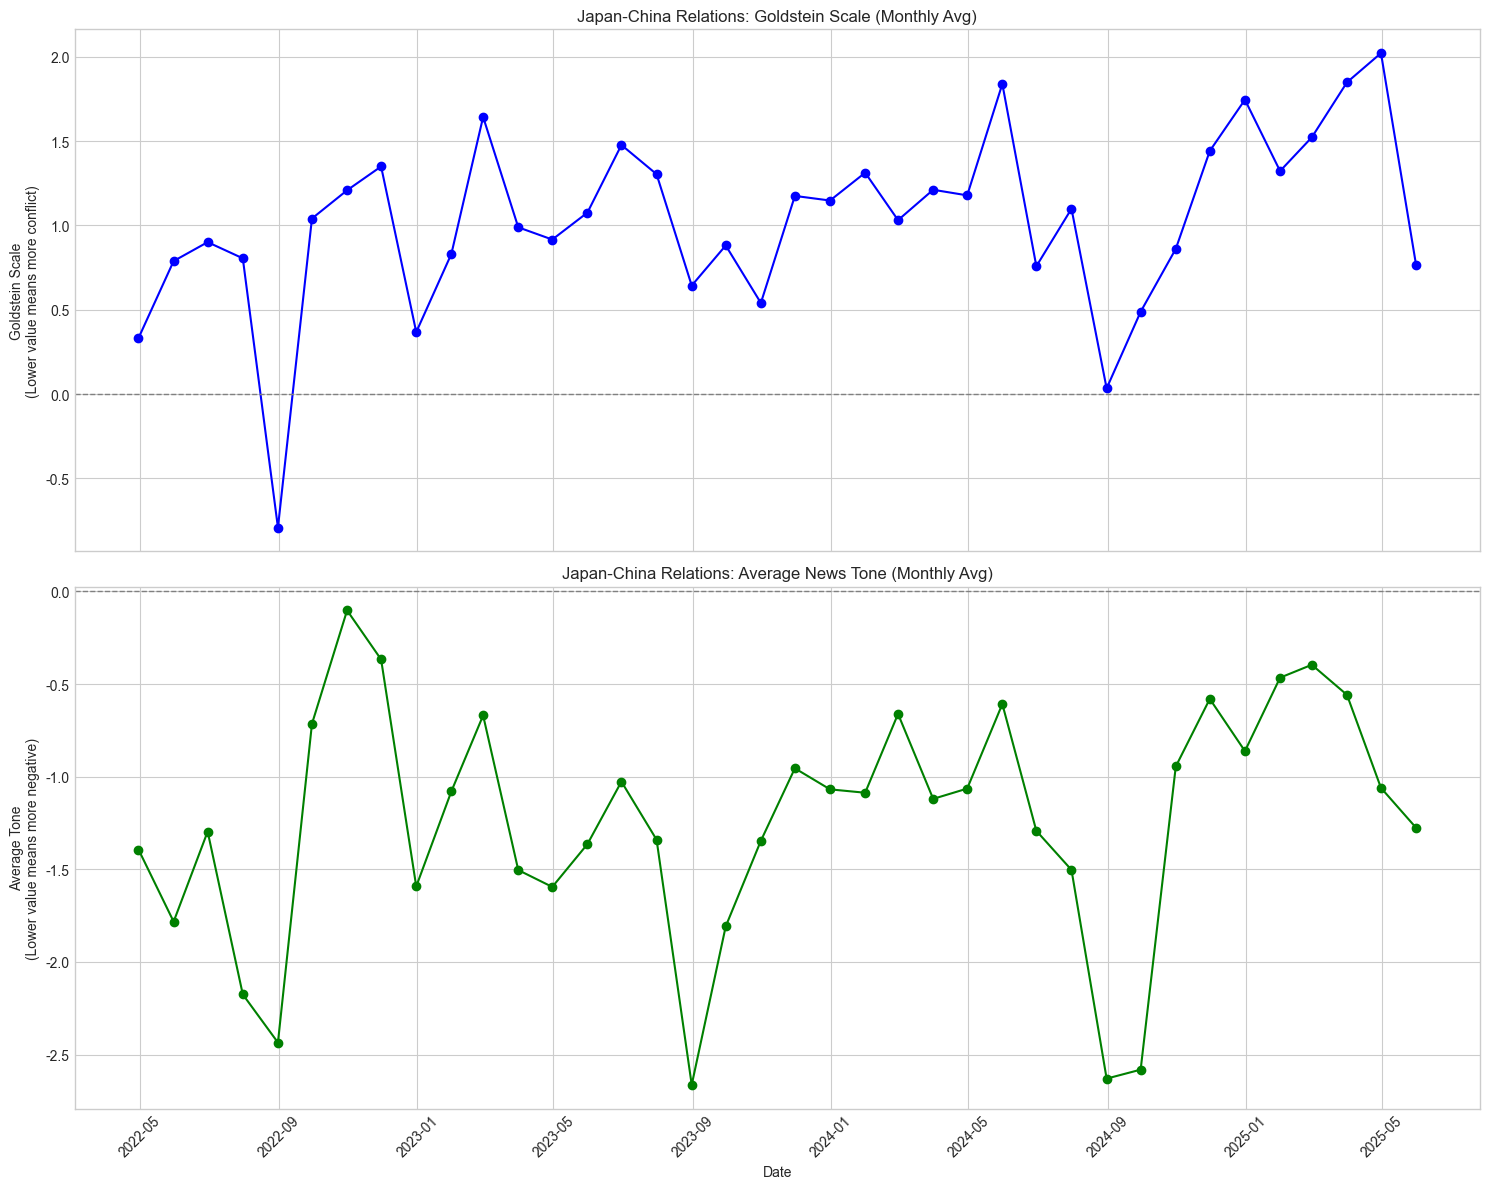

[########################################] | 100% Completed | 1.80 sms


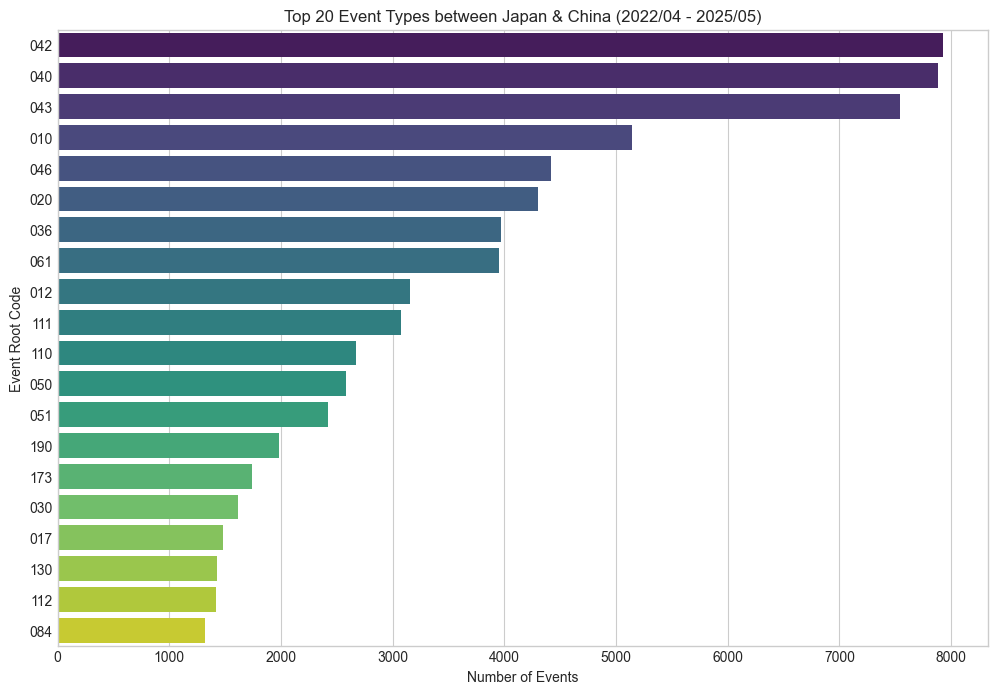

For CAMEO event code details, see https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt
[########################################] | 100% Completed | 211.99 ms

--- Top 5 Most Conflictual Events ---
Date: 2022-04-01
  Actors: JAPAN and CHINA
  GoldsteinScale: -10.00, AvgTone: -5.47
  Event Code: 1
  Source URL: https://allafrica.com/stories/202204010362.html
--------------------
Date: 2022-04-01
  Actors: CHINA and JAPAN
  GoldsteinScale: -10.00, AvgTone: 0.67
  Event Code: 0
  Source URL: https://eurasiantimes.com/boosted-by-anglo-american-power-australia-looks-to-challenge-china-with-a-new-port-in-darwin-reports/
--------------------
Date: 2022-04-01
  Actors: CHINA and JAPAN
  GoldsteinScale: -10.00, AvgTone: 0.67
  Event Code: 0
  Source URL: https://eurasiantimes.com/boosted-by-anglo-american-power-australia-looks-to-challenge-china-with-a-new-port-in-darwin-reports/
--------------------
Date: 2022-04-02
  Actors: JAPANESE and CHINA
  GoldsteinScale: -10.00, AvgTone: -4.1

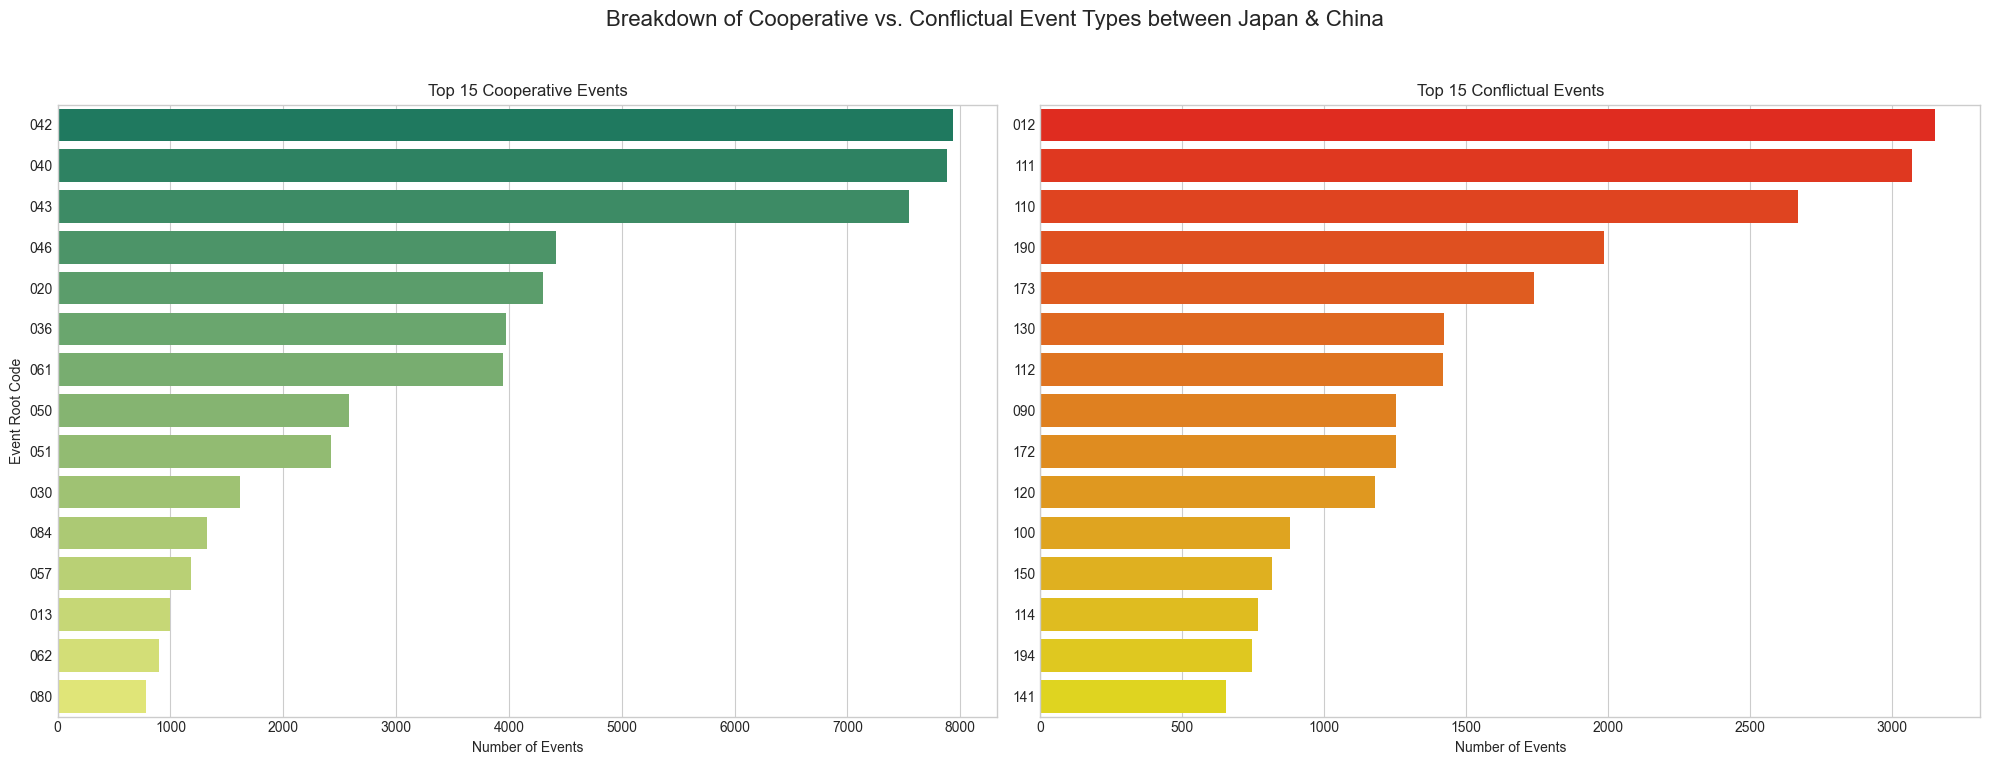

[########################################] | 100% Completed | 111.71 ms
[########################################] | 100% Completed | 210.23 ms


/var/folders/hb/cmxv2jrx4_jfkh655ftk5x3r0000gn/T/ipykernel_38173/813262726.py:169: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



[########################################] | 100% Completed | 1.26 sms


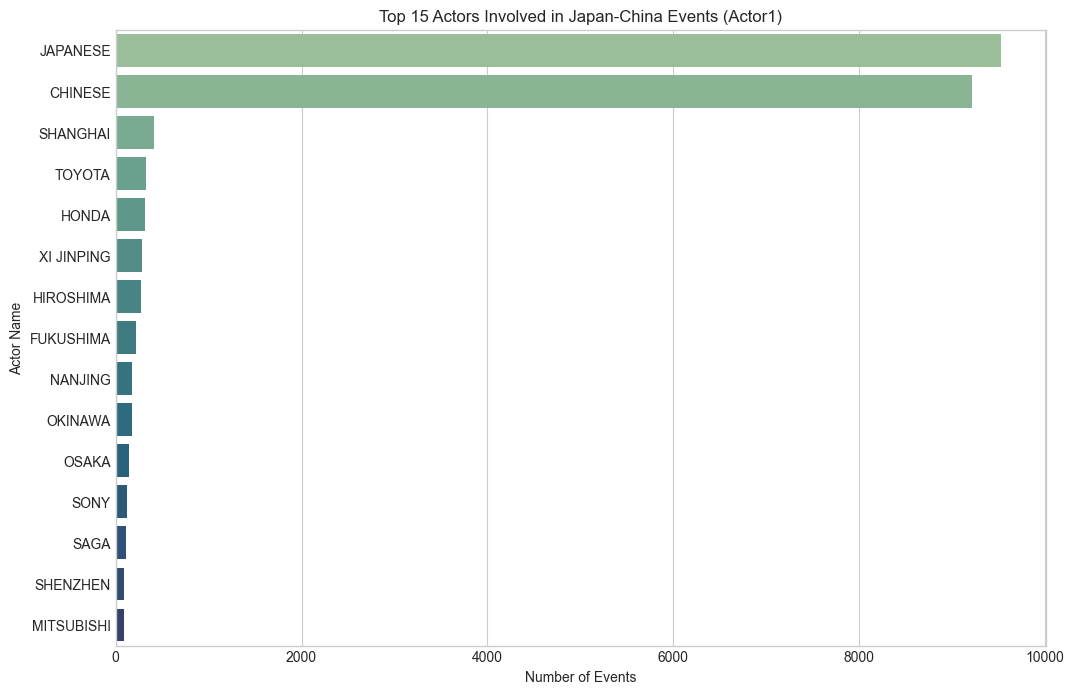

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
from pathlib import Path
from datetime import datetime
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False 

CAMEO_ROOT_CODE_MAP = {
    '01': 'Make Public Statement',
    '02': 'Appeal',
    '03': 'Express Intent to Cooperate',
    '04': 'Consult',
    '05': 'Engage in Diplomatic Cooperation',
    '06': 'Engage in Material Cooperation',
    '07': 'Provide Aid',
    '08': 'Yield',
    '09': 'Investigate',
    '10': 'Demand',
    '11': 'Disapprove',
    '12': 'Reject',
    '13': 'Threaten',
    '14': 'Protest',
    '15': 'Exhibit Force Posture',
    '16': 'Reduce Relations',
    '17': 'Coerce',
    '18': 'Assault',
    '19': 'Fight',
    '20': 'Use Unconventional Mass Violence'
}


def load_gdelt_data_dask(gdelt_path_str, columns_to_load=None):
    ddf_gdelt = None
    gdelt_path = Path(gdelt_path_str)

    if not (gdelt_path.is_dir() or (gdelt_path.is_file() and gdelt_path.suffix.lower() == '.parquet')):
        return None

    try:
        ddf_gdelt = dd.read_parquet(
            gdelt_path, 
            columns=columns_to_load,
            engine='pyarrow'
        )
        if 'SQLDATE' in ddf_gdelt.columns and not pd.api.types.is_datetime64_any_dtype(ddf_gdelt['SQLDATE'].dtype):
            ddf_gdelt['SQLDATE'] = dd.to_datetime(ddf_gdelt['SQLDATE'], errors='coerce')
    except Exception:
        return None
    return ddf_gdelt


def filter_jpn_chn_events(ddf):
    jpn_chn_filter = ((ddf['Actor1CountryCode'] == 'JPN') & (ddf['Actor2CountryCode'] == 'CHN')) | \
                     ((ddf['Actor1CountryCode'] == 'CHN') & (ddf['Actor2CountryCode'] == 'JPN'))
    return ddf[jpn_chn_filter]

def plot_jpn_chn_timeseries(df_jpn_chn):
    if not pd.api.types.is_datetime64_any_dtype(df_jpn_chn['SQLDATE'].dtype):
        df_jpn_chn['SQLDATE'] = dd.to_datetime(df_jpn_chn['SQLDATE'], errors='coerce')
        df_jpn_chn = df_jpn_chn.dropna(subset=['SQLDATE'])

    df_jpn_chn_ts = df_jpn_chn.set_index('SQLDATE')
    
    with ProgressBar():
        monthly_avg = df_jpn_chn_ts[['GoldsteinScale', 'AvgTone']].resample('M').mean().compute()
    
    if monthly_avg.empty:
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    ax1.plot(monthly_avg.index, monthly_avg['GoldsteinScale'], marker='o', linestyle='-', color='b')
    ax1.axhline(0, color='grey', linestyle='--', lw=1)
    ax1.set_title('Japan-China Relations: Goldstein Scale (Monthly Avg)')
    ax1.set_ylabel('Goldstein Scale\n(Lower value means more conflict)')
    ax1.grid(True)

    ax2.plot(monthly_avg.index, monthly_avg['AvgTone'], marker='o', linestyle='-', color='g')
    ax2.axhline(0, color='grey', linestyle='--', lw=1)
    ax2.set_title('Japan-China Relations: Average News Tone (Monthly Avg)')
    ax2.set_ylabel('Average Tone\n(Lower value means more negative)')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_jpn_chn_event_types(df_jpn_chn, top_n=20):
    with ProgressBar():
        event_counts = df_jpn_chn['EventRootCode'].value_counts().compute().nlargest(top_n)
    
    if event_counts.empty:
        return

    event_counts.index = event_counts.index.map(CAMEO_ROOT_CODE_MAP).fillna(event_counts.index)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=event_counts.values, y=event_counts.index, orient='h', palette='viridis')
    plt.title(f'Top {top_n} Event Types between Japan & China (2022/04 - 2025/05)')
    plt.xlabel('Number of Events')
    plt.ylabel('Event Type')
    plt.show()
    print("For CAMEO event code details, see https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt")

def analyze_jpn_chn_conflict_peaks(df_jpn_chn, n_events=5):
    cols_to_show = ['SQLDATE', 'Actor1Name', 'Actor2Name', 'GoldsteinScale', 'AvgTone', 'EventCodeFull', 'EventRootCode', 'SOURCEURL']
    available_cols = [col for col in cols_to_show if col in df_jpn_chn.columns]
    
    if 'GoldsteinScale' not in available_cols:
        return
    
    with ProgressBar():
        most_conflict = df_jpn_chn[available_cols].nsmallest(n_events, 'GoldsteinScale').compute()
    
    print(f"\n--- Top {n_events} Most Conflictual Events ---")
    if not most_conflict.empty:
        for _, row in most_conflict.iterrows():
            print(f"Date: {row['SQLDATE'].strftime('%Y-%m-%d')}")
            if 'Actor1Name' in row and 'Actor2Name' in row:
                print(f"  Actors: {row['Actor1Name']} and {row['Actor2Name']}")
            print(f"  GoldsteinScale: {row['GoldsteinScale']:.2f}, AvgTone: {row['AvgTone']:.2f}")
            if 'EventRootCode' in row:
                event_type_str = CAMEO_ROOT_CODE_MAP.get(row['EventRootCode'], 'Unknown')
                print(f"  Event Type: {event_type_str} (Code: {row.get('EventCodeFull', 'N/A')})")
            elif 'EventCodeFull' in row:
                 print(f"  Event Code: {row['EventCodeFull']}")
            if 'SOURCEURL' in row:
                print(f"  Source URL: {row['SOURCEURL']}")
            print("-" * 20)
    else:
        print("No data found.")

def plot_jpn_chn_event_breakdown(ddf_jpn_chn, top_n=15):
    coop_events = ddf_jpn_chn[ddf_jpn_chn['GoldsteinScale'] > 0]
    conf_events = ddf_jpn_chn[ddf_jpn_chn['GoldsteinScale'] < 0]

    with ProgressBar():
        coop_counts = coop_events['EventRootCode'].value_counts().nlargest(top_n).compute()
        conf_counts = conf_events['EventRootCode'].value_counts().nlargest(top_n).compute()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Breakdown of Cooperative vs. Conflictual Event Types between Japan & China', fontsize=16)

    if not coop_counts.empty:
        coop_counts.index = coop_counts.index.map(CAMEO_ROOT_CODE_MAP).fillna(coop_counts.index)
        sns.barplot(ax=ax1, x=coop_counts.values, y=coop_counts.index, orient='h', palette='summer')
        ax1.set_title(f'Top {top_n} Cooperative Events')
        ax1.set_xlabel('Number of Events')
        ax1.set_ylabel('Event Type')
    else:
        ax1.text(0.5, 0.5, 'No cooperative event data', ha='center', va='center')
        ax1.set_title(f'Top {top_n} Cooperative Events')

    if not conf_counts.empty:
        conf_counts.index = conf_counts.index.map(CAMEO_ROOT_CODE_MAP).fillna(conf_counts.index)
        sns.barplot(ax=ax2, x=conf_counts.values, y=conf_counts.index, orient='h', palette='autumn')
        ax2.set_title(f'Top {top_n} Conflictual Events')
        ax2.set_xlabel('Number of Events')
        ax2.set_ylabel('')
    else:
        ax2.text(0.5, 0.5, 'No conflictual event data', ha='center', va='center')
        ax2.set_title(f'Top {top_n} Conflictual Events')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_jpn_chn_event_map(ddf_jpn_chn, sample_size=2000):
    map_cols = ['ActionGeo_Lat', 'ActionGeo_Long', 'GoldsteinScale', 'NumMentions', 'Actor1Name', 'Actor2Name', 'ActionGeo_Fullname']
    available_map_cols = [col for col in map_cols if col in ddf_jpn_chn.columns]
    
    if 'ActionGeo_Lat' not in available_map_cols or 'ActionGeo_Long' not in available_map_cols:
        return

    significant_events = ddf_jpn_chn[abs(ddf_jpn_chn['GoldsteinScale']) >= 3]
    
    with ProgressBar():
        significant_count = len(significant_events)
        if significant_count > 0:
            frac = min(1.0, sample_size / significant_count if significant_count > 0 else 1.0)
            map_data_pd = significant_events[available_map_cols].sample(frac=frac, random_state=42).compute()
        else:
            map_data_pd = pd.DataFrame(columns=available_map_cols)
    
    if map_data_pd.empty:
        return

    map_data_pd.dropna(subset=['ActionGeo_Lat', 'ActionGeo_Long'], inplace=True)
    if map_data_pd.empty:
        return

    fig = px.scatter_mapbox(
        map_data_pd,
        lat="ActionGeo_Lat",
        lon="ActionGeo_Long",
        color="GoldsteinScale",
        size="NumMentions",
        color_continuous_scale=px.colors.diverging.RdYlBu,
        size_max=15,
        zoom=2,
        mapbox_style="carto-positron",
        title="Map of Japan-China Related Event Locations",
        hover_name="ActionGeo_Fullname",
        hover_data={"Actor1Name": True, "Actor2Name": True, "NumMentions": True, "GoldsteinScale": True}
    )
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()

def plot_jpn_chn_top_actors(ddf_jpn_chn, top_n=15):
    if 'Actor1Name' not in ddf_jpn_chn.columns:
        return
        
    generic_names = ['JAPAN', 'CHINA', 'BEIJING', 'TOKYO']
    filtered_actors = ddf_jpn_chn[~ddf_jpn_chn['Actor1Name'].isin(generic_names)]
    
    with ProgressBar():
        top_actors = filtered_actors['Actor1Name'].value_counts().nlargest(top_n).compute()

    if top_actors.empty:
        return

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_actors.values, y=top_actors.index, orient='h', palette='crest')
    plt.title(f'Top {top_n} Actors Involved in Japan-China Events (Actor1)')
    plt.xlabel('Number of Events')
    plt.ylabel('Actor Name')
    plt.show()

if __name__ == '__main__':
    analysis_start_date = datetime(2022, 4, 1)
    analysis_end_date   = datetime(2025, 5, 30)

    gdelt_filename = f"gdelt_events_20220401_20250609.parquet"
    gdelt_output_dir = Path("data") 
    GDELT_PARQUET_PATH = gdelt_output_dir / gdelt_filename
    
    columns_to_load = [
        "SQLDATE", "Actor1CountryCode", "Actor2CountryCode", "EventRootCode",
        "GoldsteinScale", "AvgTone", "EventCodeFull", 
        "Actor1Name", "Actor2Name", "SOURCEURL",
        "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_Fullname", "NumMentions"
    ]

    ddf_gdelt_raw = load_gdelt_data_dask(
        str(GDELT_PARQUET_PATH),
        columns_to_load=columns_to_load
    )

    if ddf_gdelt_raw is not None and ddf_gdelt_raw.npartitions > 0:
        
        if not pd.api.types.is_datetime64_any_dtype(ddf_gdelt_raw['SQLDATE'].dtype):
            ddf_gdelt_raw['SQLDATE'] = dd.to_datetime(ddf_gdelt_raw['SQLDATE'], errors='coerce')
        
        ddf_gdelt_period_filtered = ddf_gdelt_raw[
            (ddf_gdelt_raw['SQLDATE'] >= analysis_start_date) & 
            (ddf_gdelt_raw['SQLDATE'] <= analysis_end_date)
        ]
        
        ddf_jpn_chn_filtered = filter_jpn_chn_events(ddf_gdelt_period_filtered)
        
        with ProgressBar():
            ddf_jpn_chn_persisted = ddf_jpn_chn_filtered.persist()
        
        with ProgressBar():
            row_count = len(ddf_jpn_chn_persisted)
        
        if row_count > 0:
            print(f"Number of extracted Japan-China events: {row_count}")
            
            plot_jpn_chn_timeseries(ddf_jpn_chn_persisted)
            plot_jpn_chn_event_types(ddf_jpn_chn_persisted, top_n=20)
            analyze_jpn_chn_conflict_peaks(ddf_jpn_chn_persisted, n_events=5)
            plot_jpn_chn_event_breakdown(ddf_jpn_chn_persisted, top_n=15)
            plot_jpn_chn_event_map(ddf_jpn_chn_persisted, sample_size=2000)
            plot_jpn_chn_top_actors(ddf_jpn_chn_persisted, top_n=15)



- Goldsteinスケールはプラスとマイナスの間を大きく変動しており、日中関係が安定的ではないことを示している
- 日中関係に関する報道は全体としてネガティブな論調でなされる傾向
- 「訪問」「協議」「訪問の受け入れ」といった対話関連が多い。まずは対話という姿勢が出ているのか
- 012（非難）、111（外交関係悪化）、110（外交的非難）といった言語的・外交的な対立が上位を占めている
- 両国の主要都市が上位にあるこれは、地名から歴史認識や経済特区などに関連していると考えられる
- TYOTA, HONDA, SONY, MITSUBISHI といった日本企業が多数ランクインしており、日中関係において製造業が非常に重要な位置を占めている

## 米中関係のグラフ化

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import plotly.express as px
from pathlib import Path
from datetime import datetime
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['axes.unicode_minus'] = False 

CAMEO_ROOT_CODE_MAP = {
    '01': 'Make Public Statement',
    '02': 'Appeal',
    '03': 'Express Intent to Cooperate',
    '04': 'Consult',
    '05': 'Engage in Diplomatic Cooperation',
    '06': 'Engage in Material Cooperation',
    '07': 'Provide Aid',
    '08': 'Yield',
    '09': 'Investigate',
    '10': 'Demand',
    '11': 'Disapprove',
    '12': 'Reject',
    '13': 'Threaten',
    '14': 'Protest',
    '15': 'Exhibit Force Posture',
    '16': 'Reduce Relations',
    '17': 'Coerce',
    '18': 'Assault',
    '19': 'Fight',
    '20': 'Use Unconventional Mass Violence'
}


def load_gdelt_data_dask(gdelt_path_str, columns_to_load=None):
    """Load GDELT Parquet data as a Dask DataFrame"""
    ddf_gdelt = None
    gdelt_path = Path(gdelt_path_str)

    if not (gdelt_path.is_dir() or (gdelt_path.is_file() and gdelt_path.suffix.lower() == '.parquet')):
        print(f"Error: GDELT Parquet path '{gdelt_path}' not found or is not a valid Parquet directory/file.")
        return None

    try:
        print(f"Loading with Dask: {gdelt_path} (Columns: {columns_to_load if columns_to_load else 'All'})")
        ddf_gdelt = dd.read_parquet(
            gdelt_path, 
            columns=columns_to_load,
            engine='pyarrow'
        )
        print(f"Loaded Dask DataFrame from '{gdelt_path}'. Number of partitions: {ddf_gdelt.npartitions}")
        
        if 'SQLDATE' in ddf_gdelt.columns and not pd.api.types.is_datetime64_any_dtype(ddf_gdelt['SQLDATE'].dtype):
            ddf_gdelt['SQLDATE'] = dd.to_datetime(ddf_gdelt['SQLDATE'], errors='coerce')

    except Exception as e:
        print(f"Error: Failed to load Dask DataFrame from '{gdelt_path}': {e}")
        return None
    return ddf_gdelt

def filter_usa_chn_events(ddf):
    """Filter events involving the United States and China"""
    print("Filtering for events involving USA and China (CHN)...")
    usa_chn_filter = ((ddf['Actor1CountryCode'] == 'USA') & (ddf['Actor2CountryCode'] == 'CHN')) | \
                     ((ddf['Actor1CountryCode'] == 'CHN') & (ddf['Actor2CountryCode'] == 'USA'))
    
    return ddf[usa_chn_filter]

def plot_usa_chn_timeseries(ddf_usa_chn):
    """Plot time-series graph of US-China relations indicators (GoldsteinScale, AvgTone)"""
    print("Aggregating monthly data for time-series plot...")
    
    if not pd.api.types.is_datetime64_any_dtype(ddf_usa_chn['SQLDATE'].dtype):
        ddf_usa_chn['SQLDATE'] = dd.to_datetime(ddf_usa_chn['SQLDATE'], errors='coerce')
        ddf_usa_chn = ddf_usa_chn.dropna(subset=['SQLDATE'])

    ddf_usa_chn_ts = ddf_usa_chn.set_index('SQLDATE')
    
    with ProgressBar():
        monthly_avg = ddf_usa_chn_ts[['GoldsteinScale', 'AvgTone']].resample('M').mean().compute()
    
    if monthly_avg.empty:
        print("Data is empty after monthly aggregation.")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    ax1.plot(monthly_avg.index, monthly_avg['GoldsteinScale'], marker='o', linestyle='-', color='b')
    ax1.axhline(0, color='grey', linestyle='--', lw=1)
    ax1.set_title('US-China Relations: Goldstein Scale (Monthly Avg)')
    ax1.set_ylabel('Goldstein Scale\n(Lower value means more conflict)')
    ax1.grid(True)

    ax2.plot(monthly_avg.index, monthly_avg['AvgTone'], marker='o', linestyle='-', color='g')
    ax2.axhline(0, color='grey', linestyle='--', lw=1)
    ax2.set_title('US-China Relations: Average News Tone (Monthly Avg)')
    ax2.set_ylabel('Average Tone\n(Lower value means more negative)')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print("Generated time-series graph of US-China relations.")

def plot_usa_chn_event_types(ddf_usa_chn, top_n=20):
    """Plot event types between the US and China"""
    print(f"Aggregating top {top_n} event types...")
    
    with ProgressBar():
        event_counts = ddf_usa_chn['EventRootCode'].value_counts().compute().nlargest(top_n)
    
    if event_counts.empty:
        print("Aggregated event type result is empty.")
        return

    # Map event codes to names for plotting
    mapped_index = event_counts.index.map(CAMEO_ROOT_CODE_MAP)
    event_counts.index = mapped_index.where(mapped_index.notna(), event_counts.index)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=event_counts.values, y=event_counts.index, orient='h', palette='viridis')
    plt.title(f'Top {top_n} Event Types between USA & China (2022/04 - 2025/05)')
    plt.xlabel('Number of Events')
    plt.ylabel('Event Type')
    plt.show()
    print("Generated bar plot of event types between the US and China.")
    print("For CAMEO event code details, see https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt")

def analyze_usa_chn_conflict_peaks(ddf_usa_chn, n_events=5):
    """Extract most conflictual events (lowest GoldsteinScale)"""
    print(f"Extracting top {n_events} most conflictual events...")
    
    cols_to_show = ['SQLDATE', 'Actor1Name', 'Actor2Name', 'GoldsteinScale', 'AvgTone', 'EventCodeFull', 'EventRootCode', 'SOURCEURL']
    available_cols = [col for col in cols_to_show if col in ddf_usa_chn.columns]
    
    if 'GoldsteinScale' not in available_cols:
        print("Skipping conflict peak analysis because GoldsteinScale column is missing.")
        return
    
    with ProgressBar():
        most_conflict = ddf_usa_chn[available_cols].nsmallest(n_events, 'GoldsteinScale').compute()
    
    print(f"\n--- Top {n_events} Most Conflictual Events ---")
    if not most_conflict.empty:
        for _, row in most_conflict.iterrows():
            print(f"Date: {row['SQLDATE'].strftime('%Y-%m-%d')}")
            if 'Actor1Name' in row and 'Actor2Name' in row:
                print(f"  Actors: {row['Actor1Name']} and {row['Actor2Name']}")
            print(f"  GoldsteinScale: {row['GoldsteinScale']:.2f}, AvgTone: {row['AvgTone']:.2f}")
            if 'EventRootCode' in row:
                event_type_str = CAMEO_ROOT_CODE_MAP.get(str(row['EventRootCode']), 'Unknown')
                print(f"  Event Type: {event_type_str} (Code: {row.get('EventCodeFull', 'N/A')})")
            elif 'EventCodeFull' in row:
                 print(f"  Event Code: {row['EventCodeFull']}")
            if 'SOURCEURL' in row:
                print(f"  Source URL: {row['SOURCEURL']}")
            print("-" * 20)
    else:
        print("No data found.")

def plot_usa_chn_event_breakdown(ddf_usa_chn, top_n=15):
    """Plot breakdown of cooperative vs conflictual event types."""
    print(f"Aggregating breakdown of cooperative vs. conflictual events (Top {top_n})...")

    coop_events = ddf_usa_chn[ddf_usa_chn['GoldsteinScale'] > 0]
    conf_events = ddf_usa_chn[ddf_usa_chn['GoldsteinScale'] < 0]

    with ProgressBar():
        coop_counts = coop_events['EventRootCode'].value_counts().nlargest(top_n).compute()
        conf_counts = conf_events['EventRootCode'].value_counts().nlargest(top_n).compute()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Breakdown of Cooperative vs. Conflictual Event Types between USA & China', fontsize=16)

    if not coop_counts.empty:
        mapped_coop_index = coop_counts.index.map(CAMEO_ROOT_CODE_MAP)
        coop_counts.index = mapped_coop_index.where(mapped_coop_index.notna(), coop_counts.index)
        sns.barplot(ax=ax1, x=coop_counts.values, y=coop_counts.index, orient='h', palette='summer')
        ax1.set_title(f'Top {top_n} Cooperative Events')
        ax1.set_xlabel('Number of Events')
        ax1.set_ylabel('Event Type')
    else:
        ax1.text(0.5, 0.5, 'No cooperative event data', ha='center', va='center')
        ax1.set_title(f'Top {top_n} Cooperative Events')

    if not conf_counts.empty:
        mapped_conf_index = conf_counts.index.map(CAMEO_ROOT_CODE_MAP)
        conf_counts.index = mapped_conf_index.where(mapped_conf_index.notna(), conf_counts.index)
        sns.barplot(ax=ax2, x=conf_counts.values, y=conf_counts.index, orient='h', palette='autumn')
        ax2.set_title(f'Top {top_n} Conflictual Events')
        ax2.set_xlabel('Number of Events')
        ax2.set_ylabel('')
    else:
        ax2.text(0.5, 0.5, 'No conflictual event data', ha='center', va='center')
        ax2.set_title(f'Top {top_n} Conflictual Events')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("Generated breakdown graph of cooperative vs. conflictual events.")

def plot_usa_chn_event_map(ddf_usa_chn, sample_size=2000):
    """Plot a map of event locations between the US and China."""
    print("Creating a geographical map of event locations...")
    
    map_cols = ['ActionGeo_Lat', 'ActionGeo_Long', 'GoldsteinScale', 'NumMentions', 'Actor1Name', 'Actor2Name', 'ActionGeo_Fullname']
    available_map_cols = [col for col in map_cols if col in ddf_usa_chn.columns]
    
    if 'ActionGeo_Lat' not in available_map_cols or 'ActionGeo_Long' not in available_map_cols:
        print("Cannot generate map because geographical information is missing.")
        return

    significant_events = ddf_usa_chn[abs(ddf_usa_chn['GoldsteinScale']) >= 3]
    
    with ProgressBar():
        significant_count = len(significant_events)
        if significant_count > 0:
            frac = min(1.0, sample_size / significant_count if significant_count > 0 else 1.0)
            map_data_pd = significant_events[available_map_cols].sample(frac=frac, random_state=42).compute()
        else:
            map_data_pd = pd.DataFrame(columns=available_map_cols)
    
    if map_data_pd.empty:
        print("No data found to plot on the map.")
        return

    map_data_pd.dropna(subset=['ActionGeo_Lat', 'ActionGeo_Long'], inplace=True)
    if map_data_pd.empty:
        print("No data with valid latitude/longitude found.")
        return

    fig = px.scatter_mapbox(
        map_data_pd,
        lat="ActionGeo_Lat",
        lon="ActionGeo_Long",
        color="GoldsteinScale",
        size="NumMentions",
        color_continuous_scale=px.colors.diverging.RdYlBu,
        size_max=15,
        zoom=1,
        mapbox_style="carto-positron",
        title="Map of US-China Related Event Locations",
        hover_name="ActionGeo_Fullname",
        hover_data={"Actor1Name": True, "Actor2Name": True, "NumMentions": True, "GoldsteinScale": True}
    )
    fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
    fig.show()
    print("Generated event location map.")

def plot_usa_chn_top_actors(ddf_usa_chn, top_n=15):
    """Analyze and plot the top actors involved in US-CHN events."""
    print(f"Aggregating top {top_n} involved actors...")
    if 'Actor1Name' not in ddf_usa_chn.columns:
        print("Skipping actor analysis because Actor1Name column is missing.")
        return
        
    generic_names = ['UNITED STATES', 'CHINA', 'BEIJING', 'WASHINGTON', 'TAIWAN']
    filtered_actors = ddf_usa_chn[~ddf_usa_chn['Actor1Name'].isin(generic_names)]
    
    with ProgressBar():
        top_actors = filtered_actors['Actor1Name'].value_counts().nlargest(top_n).compute()

    if top_actors.empty:
        return

    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_actors.values, y=top_actors.index, orient='h', palette='crest')
    plt.title(f'Top {top_n} Actors Involved in US-China Events (Actor1)')
    plt.xlabel('Number of Events')
    plt.ylabel('Actor Name')
    plt.show()
    print("Generated graph of top involved actors.")


if __name__ == '__main__':
    analysis_start_date = datetime(2022, 4, 1)
    analysis_end_date   = datetime(2025, 6, 9)

    gdelt_filename = f"gdelt_events_20220401_20250609.parquet"
    gdelt_output_dir = Path("data") 
    GDELT_PARQUET_PATH = gdelt_output_dir / gdelt_filename
    
    columns_to_load = [
        "SQLDATE", "Actor1CountryCode", "Actor2CountryCode", "EventRootCode",
        "GoldsteinScale", "AvgTone", "EventCodeFull", 
        "Actor1Name", "Actor2Name", "SOURCEURL",
        "ActionGeo_Lat", "ActionGeo_Long", "ActionGeo_Fullname", "NumMentions"
    ]

    ddf_gdelt_raw = load_gdelt_data_dask(
        str(GDELT_PARQUET_PATH),
        columns_to_load=columns_to_load
    )

    if ddf_gdelt_raw is not None and ddf_gdelt_raw.npartitions > 0:
        
        if not pd.api.types.is_datetime64_any_dtype(ddf_gdelt_raw['SQLDATE'].dtype):
            ddf_gdelt_raw['SQLDATE'] = dd.to_datetime(ddf_gdelt_raw['SQLDATE'], errors='coerce')
        
        ddf_gdelt_period_filtered = ddf_gdelt_raw[
            (ddf_gdelt_raw['SQLDATE'] >= analysis_start_date) & 
            (ddf_gdelt_raw['SQLDATE'] <= analysis_end_date)
        ]
        
        ddf_usa_chn_filtered = filter_usa_chn_events(ddf_gdelt_period_filtered)
        
        print("Persisting filtered results in memory. This may take some time...")
        with ProgressBar():
            ddf_usa_chn_persisted = ddf_usa_chn_filtered.persist()
        
        print("Calculating number of events from persisted data...")
        with ProgressBar():
            row_count = len(ddf_usa_chn_persisted)
        
        if row_count > 0:
            print(f"Number of extracted US-China events: {row_count}")
            
            plot_usa_chn_timeseries(ddf_usa_chn_persisted)
            plot_usa_chn_event_types(ddf_usa_chn_persisted, top_n=20)
            analyze_usa_chn_conflict_peaks(ddf_usa_chn_persisted, n_events=5)
            plot_usa_chn_event_breakdown(ddf_usa_chn_persisted, top_n=15)
            plot_usa_chn_event_map(ddf_usa_chn_persisted, sample_size=2000)
            plot_usa_chn_top_actors(ddf_usa_chn_persisted, top_n=15)

        else:
            print("No events involving the US and China were found in the specified period.")

    else:
        print("Skipping analysis because GDELT Dask DataFrame is empty or failed to load.")

    print("\nAnalysis finished.")


Loading with Dask: data/gdelt_events_20220401_20250609.parquet (Columns: ['SQLDATE', 'Actor1CountryCode', 'Actor2CountryCode', 'EventRootCode', 'GoldsteinScale', 'AvgTone', 'EventCodeFull', 'Actor1Name', 'Actor2Name', 'SOURCEURL', 'ActionGeo_Lat', 'ActionGeo_Long', 'ActionGeo_Fullname', 'NumMentions'])
Loaded Dask DataFrame from 'data/gdelt_events_20220401_20250609.parquet'. Number of partitions: 57
Filtering for events involving USA and China (CHN)...
Persisting filtered results in memory. This may take some time...
[######################                  ] | 55% Completed | 104.00 s

- Goldsteinスケールは平均して良い傾向にあるが、上下に触れていることから関係が不安定
- ニュースに関する平均トーンは一貫して負の領域にあり、米中関係に関する報道が全体としてネガティブな論調
- 020 (物質的協力) や051 (経済協力) といった協力的なイベントと並んで、112 (外交関係の悪化) や 130 (脅迫) といった対立的なイベントも入っている
- CHINESE, THE US, AMERICANが上位を占め、特定の政府機関だけでなく国民を指す言葉が上位に来ている
- 特定の人物や政治の主要な場所がランクインしており、リーダーの動向が関係の中心的